# Libraries & Load the Datasets

In [1]:
import sys, os, io, gc
import numpy as np
import pandas as pd
import riiideducation

import lightgbm as lgbm
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

np.seterr(divide = 'ignore', invalid = 'ignore')
print("Setup Complete")

Setup Complete


In [2]:
train = pd.read_pickle('../input/riiid-train-dataset/riiid-test-answer-prediction-train.pkl.gzip')
print('Train Size', train.shape)

Train Size (101230332, 10)


In [3]:
lectures = pd.read_csv('../input/riiid-test-answer-prediction/lectures.csv')
print('Lectures ds Size', lectures.shape)

Lectures ds Size (418, 4)


In [4]:
questions = pd.read_csv('../input/riiid-test-answer-prediction/questions.csv',
                        usecols=[0, 1, 3, 4],
                        dtype={'question_id': 'int16', 'bundle_id': 'int16', 'part': 'int8'})
print('Questions ds Size', questions.shape)

Questions ds Size (13523, 4)


# Data Processing

In [5]:
def reduce_memory_usage(df):
    """ 
    iterate through all the columns of a dataframe and 
    modify the data type to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print(('Memory usage of dataframe is {:.2f}' 
                     'MB').format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max <\
                  np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max <\
                   np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max <\
                   np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max <\
                   np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max <\
                   np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max <\
                   np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print(('Memory usage after optimization is: {:.2f}' 
                              'MB').format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) 
                                             / start_mem))
    
    return df

In [6]:
def percentage_missing_values(df):
    missing_values_count = df.isnull().sum()
    total_cells = np.product(df.shape)
    total_missing = missing_values_count.sum()
    print ("Percentage of Missing Data = ",(total_missing/total_cells) * 100,"%")

### Training Dataset

In [7]:
for col in ['prior_question_elapsed_time']: 
     train[col] = winsorize(train[col], limits=0.05)

In [8]:
train = train[train['answered_correctly'] != -1].reset_index(drop=True)
train.drop(columns=['timestamp'], inplace=True)

In [9]:
le = LabelEncoder()
train['prior_question_had_explanation'].fillna(False, inplace = True)
train['prior_question_had_explanation'] = train['prior_question_had_explanation'].astype('uint8')
train['prior_question_had_explanation'] = le.fit_transform(train['prior_question_had_explanation'])

In [10]:
# Answer for the previous questions of users
train['lag'] = train.groupby('user_id')['answered_correctly'].shift()
train['lag'].fillna(0, inplace=True)

In [11]:
# For each user (groupby('user_id')), compute the cummulative number of correct answers and number answers in general
cum = train.groupby('user_id')['lag'].agg(['cumsum', 'cumcount'])
# User correctness (measure the users' learning progress)
train['user_correctness'] = cum['cumsum']/cum['cumcount']
train.drop(['lag'], axis = 1, inplace = True)
del cum

In [12]:
# Overall correctness of users
user_agg = train.groupby('user_id')['answered_correctly'].agg(['sum', 'count'])
# Overall difficulty of questions
content_agg = train.groupby('content_id')['answered_correctly'].agg(['sum', 'count'])

In [13]:
train['residual'] =  train['answered_correctly'] - train['content_id'].map(content_agg['sum'] / content_agg['count'])
residual_agg = train.groupby('user_id')['residual'].agg(['sum'])

In [14]:
prior_question_elapsed_time_agg = train.groupby('user_id').agg({'prior_question_elapsed_time': ['sum', lambda x: len(x)]})
prior_question_elapsed_time_agg.columns = ['sum', 'count']
prior_question_elapsed_time_agg['count'] = prior_question_elapsed_time_agg['count'].astype('int32')

In [15]:
train = reduce_memory_usage(train)

Memory usage of dataframe is 4165.59MB
Memory usage after optimization is: 2366.81MB
Decreased by 43.2%


### Questions Dataset

In [16]:
unique_tags_combos_keys = {v:i for i,v in enumerate(questions['tags'].unique())}
questions['tags_encoded'] = questions['tags'].apply(lambda x : unique_tags_combos_keys[x])
questions['tags_encoded'] = pd.to_numeric(questions['tags_encoded'], downcast='integer')

In [17]:
def extract_tag_factory(tag_pos):
    def extract_tag(x):
        if isinstance(x, str) and tag_pos < len(x.split()):
            splits = x.split()
            splits.sort()
            return int(splits[tag_pos])
        else:
            return 255
    return extract_tag

In [18]:
for i in range(0, 3):
    questions[f'tag_{i + 1}'] = questions['tags'].apply(extract_tag_factory(i))
    questions[f'tag_{i + 1}'] = questions[f'tag_{i + 1}'].astype('uint8')

### Training & Validation Sets

In [19]:
train = pd.merge(train, questions, left_on='content_id', right_on='question_id', how='left')
train.drop(columns=['question_id'], inplace=True)

In [20]:
# How many questions have been answered in each content ID?
train['content_count'] = train['content_id'].map(content_agg['count']).astype('int32')
# How hard are questions in each content ID?
train['content_id'] = train['content_id'].map(content_agg['sum']/content_agg['count'])
# Deviation from the mean
train['residual_user_mean'] = train['user_id'].map(residual_agg['sum'] / user_agg['count'])

In [21]:
train['prior_question_elapsed_time_mean'] = train['user_id'].map(prior_question_elapsed_time_agg['sum'] / prior_question_elapsed_time_agg['count'])

In [22]:
train['prior_question_elapsed_time'].fillna(train['prior_question_elapsed_time'].mean(), inplace=True)
train['user_correctness'].fillna(train['user_correctness'].mean(), inplace=True)

In [23]:
percentage_missing_values(train)

Percentage of Missing Data =  0.018883173111031513 %


In [24]:
train['user_correctness'].mean()

nan

In [25]:
# Take only 200 last observations of each user
train = train.groupby('user_id').tail(200).reset_index(drop=True)

In [26]:
# 10% of the training set
valid = train.groupby('user_id').tail(20)
train.drop(valid.index, inplace=True)

In [27]:
print('Train Size', train.shape)
print('Valid Size', valid.shape)  

Train Size (24615031, 21)
Valid Size (7600841, 21)


In [28]:
train = reduce_memory_usage(train)

Memory usage of dataframe is 1666.71MB
Memory usage after optimization is: 1314.64MB
Decreased by 21.1%


In [29]:
valid = reduce_memory_usage(valid)

Memory usage of dataframe is 514.66MB


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Memory usage after optimization is: 405.98MB
Decreased by 21.1%


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Build & Train the Model

In [30]:
features = [
    'part',
    'tag_1',
    'tag_2',
    'tags_encoded',
    'content_id',
    'content_count',
    'user_correctness',
    'residual_user_mean',
    'prior_question_had_explanation',
    'prior_question_elapsed_time',
    'prior_question_elapsed_time_mean'
]

cfeatures = [
    'part',
    'tag_1',
    'tag_2',
    'tags_encoded'
]

In [31]:
parameters = {
    'objective': 'binary',
    'keep_training_booster': True,
    'num_iterations': 200,
    'learning_rate':0.3,
    'early_stopping_rounds': 10,
    'metrics': {'auc'},
}

In [32]:
dtrain = lgbm.Dataset(train[features], train['answered_correctly'], categorical_feature = cfeatures) 
dvalid = lgbm.Dataset(valid[features], valid['answered_correctly'], reference = dtrain, categorical_feature = cfeatures)

In [33]:
def lgbm_train():
    evals_result = {}
    model = lgbm.train(parameters, dtrain, valid_sets = [dtrain, dvalid], evals_result=evals_result, verbose_eval=20)
    model.save_model(f'model.txt')
    return model, evals_result

In [34]:
%%time
model, evals_result = lgbm_train()

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[20]	training's auc: 0.769447	valid_1's auc: 0.780283
[40]	training's auc: 0.770677	valid_1's auc: 0.781852
[60]	training's auc: 0.771278	valid_1's auc: 0.782393
[80]	training's auc: 0.771659	valid_1's auc: 0.782667
[100]	training's auc: 0.772015	valid_1's auc: 0.782954
[120]	training's auc: 0.772305	valid_1's auc: 0.78317
[140]	training's auc: 0.772511	valid_1's auc: 0.783298
[160]	training's auc: 0.772663	valid_1's auc: 0.78336
[180]	training's auc: 0.772821	valid_1's auc: 0.78346
[200]	training's auc: 0.773002	valid_1's auc: 0.783584
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.773002	valid_1's auc: 0.783584
CPU times: user 1h 13min 18s, sys: 1min 5s, total: 1h 14min 23s
Wall time: 24min 23s


# Validation & Reexamining the Features

### AUC

In [35]:
y_pred = model.predict(train[features])
y_true = np.array(train['answered_correctly'])
train_score = roc_auc_score(y_true, y_pred)
print('Train ROC AUC Score', train_score)

Train ROC AUC Score 0.7730016465218491


In [36]:
y_pred = model.predict(valid[features])
y_true = np.array(valid['answered_correctly'])
valid_score = roc_auc_score(y_true, y_pred)
print('Valid ROC AUC Score', valid_score)

Valid ROC AUC Score 0.783583728825146


### Training History

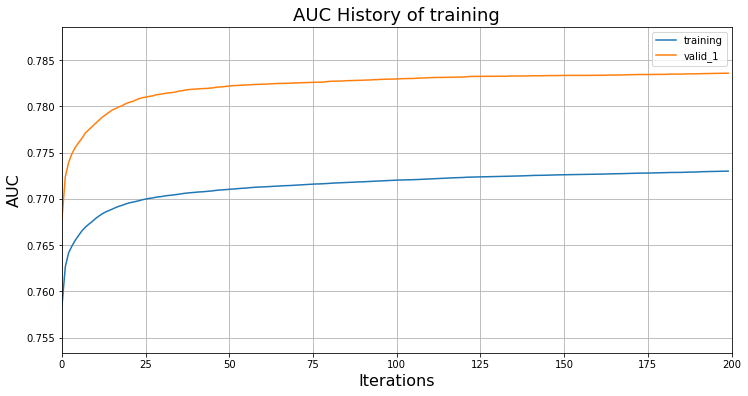

In [37]:
lgbm.plot_metric(evals_result,figsize=(12, 6), metric='auc')
plt.title('AUC History of training', fontsize=18)
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('AUC', fontsize=16)
plt.show()

### Feature Importance

Split: result contains numbers of times the feature is used in a model
Gain: result contains total gains of splits which use the feature


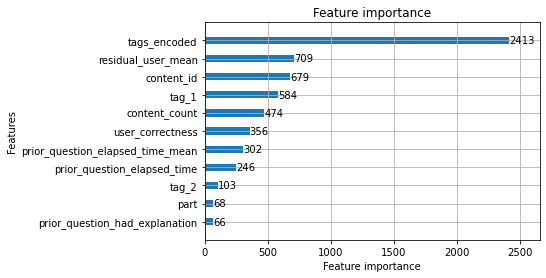

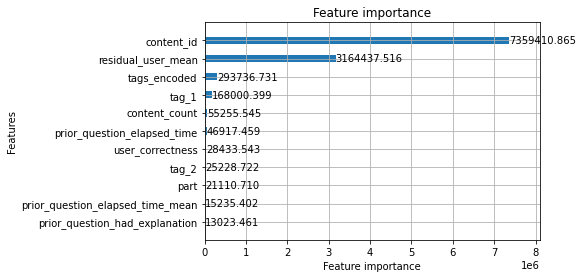

In [38]:
def plot_importance(model):
    print('Split: result contains numbers of times the feature is used in a model')
    lgbm.plot_importance(model, height=0.4) # precision=3
    print('Gain: result contains total gains of splits which use the feature')
    lgbm.plot_importance(model, height=0.4, importance_type='gain')
    plt.show()

plot_importance(model)  

### Tree Diagraph

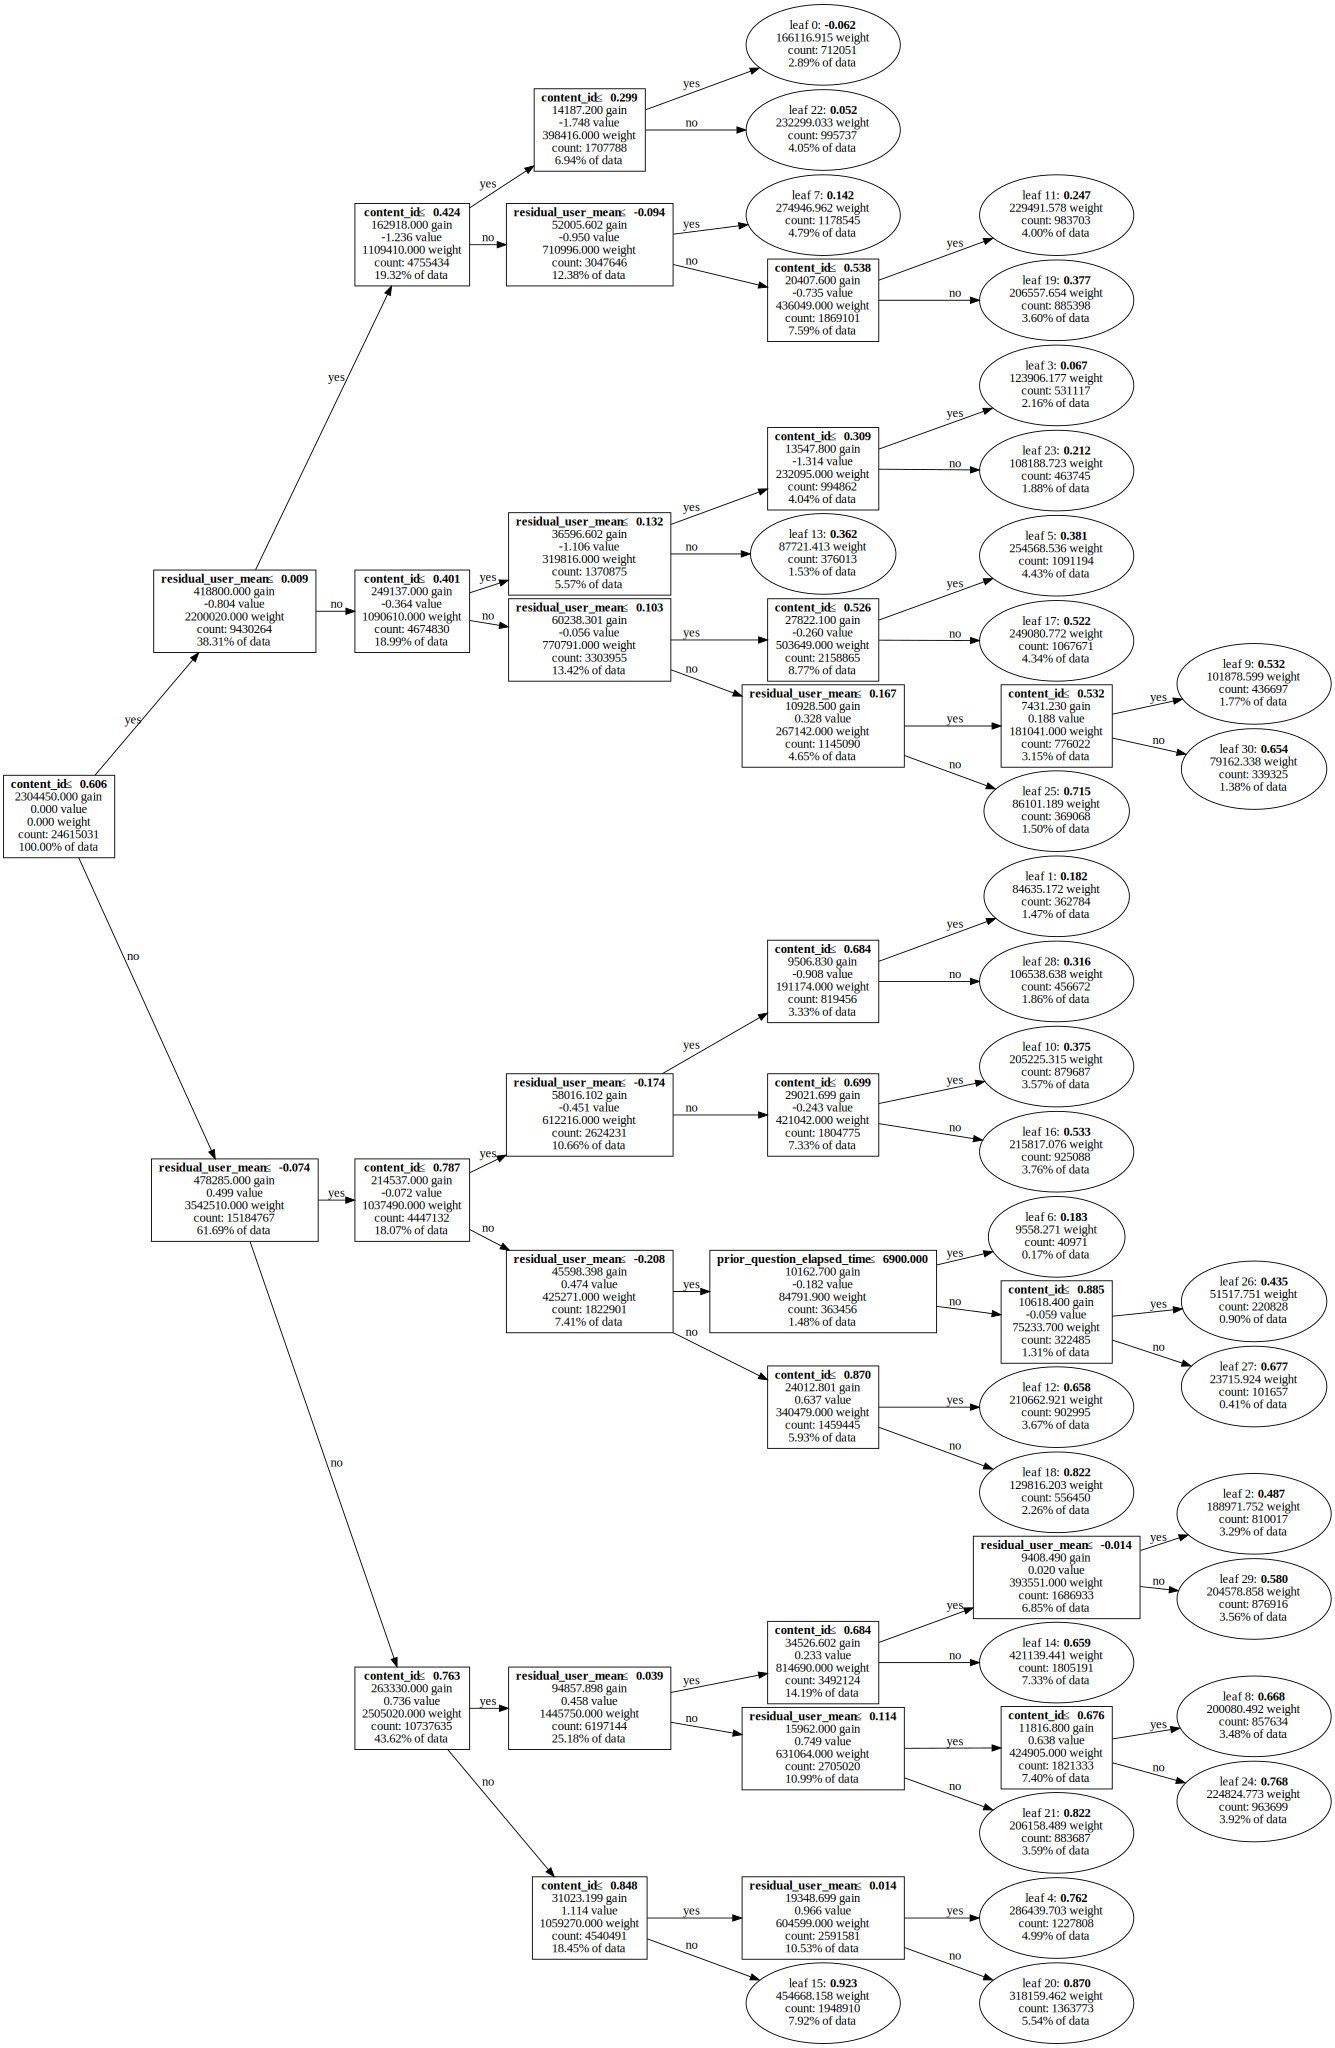

In [39]:
lgbm.create_tree_digraph(model, show_info=['split_gain', 'internal_value', 'internal_count', 'internal_weight', 'leaf_count', 'leaf_weight', 'data_percentage'])